# Phase Shift Approach - Velocity Measurements

Castelletti et al. searches for the correct slope of a surface by sweeping ranges/velocities and finding the correct phase correction by maximizing post-summed SNR. Here, we can employ a similar methodology but to find the correct spacecraft velocity.

- Surface echoes from Europa for ranging measurements will arrive later as the spacecraft moves away from the moon. 
- We can sum the received signals, each shifted with a phase correction $\Delta \phi$, to maximize post-summed SNR.
- We sweep ranging measurements to seek the correct velocities. 

This is advantageous because (i) velocity measurements can occur alongside ranging, without previous constraints from Doppler frequency; (ii) aliased results can be eliminated by comparing with Clipper's orbital properties in SPICE; and (iii) uncertainties in range and velocity can be found, across the parameter space.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy
import matplotlib.ticker as mticker

### 1) Model surface echoes (ranging measurements) from Europa 
Modelling chirps with a changing time delay (depends on Clipper's range), and with amplitude decreasing with $\frac{1}{16 \pi d^4}$.
### 2) Shift surface echoes by phase, for a velocity 
For each of the surface echoes above, shift surface echoes by a phase for each velocity. Change in phase shift = $2 \pi \Delta d / \lambda$ from Sean's paper.

In [2]:
# REASON parameters
Pt = 10 # W
Gt = 10**(6/10) # 6 dB -> B
c = 2.998e8 # m/s
rcs = 2.5e10 # for HF, but we can assume for both

hf_wavelength = c/(9e6) # m
vhf_wavelength = c/(60e6) # m

# Set parameters
hf_pulse_length = 200e-6 # s
hf_repetition_freq = 4000 # Hz
hf_bandwidth = 1e6 # Hz
hf_s = hf_bandwidth/hf_pulse_length
hf_chirp_rate = hf_bandwidth/hf_pulse_length # Hz/s
hf_fc = 0 # Hz #9e6 is true value

vhf_pulse_length = 236e-6 # s
vhf_repetition_freq = 4000 # Hz
vhf_bandwidth = 10e6 # Hz
vhf_s = vhf_bandwidth/vhf_pulse_length
vhf_chirp_rate = vhf_bandwidth/vhf_pulse_length # Hz/s
vhf_fc = 60e6 # Hz

# sampling freqs
# 2x complex-valued baseband sampling rate
hf_fs = 2.4e6 
vhf_fs = 24e6

In [3]:
def radar_equation(Pt, Gt, d, rcs, wavelength):
    # From the gain, determine the effective area of REASON
    Ae = (Gt*wavelength**2)/(4*np.pi)
    
    return ((Pt*Gt)/(4*np.pi*d**2))*((rcs*Ae)/(4*np.pi*d**2)) # return power received

In [4]:
def chirp(s, tau, fs, fc, start, n, phase_shift):
    # s: slope
    # tau: pulse length
    # fs: sample rate
    # fc: center frequency
    # start: starting index of chirp
    # n: the length of the chirp including zero

    dt = 1 / fs
    npts = int(tau * fs)
    t = np.arange(-npts/2, npts/2) * dt
    phase = np.pi * s * t**2 + 2 * np.pi * fc * t + phase_shift
    chirp = np.concatenate([np.zeros(start-1), np.exp(1j * phase), np.zeros(n - len(phase) - start + 1)])

    return chirp

In [5]:
# Modelling ranging measurements for various ranges
def ranging_per_v(start_alt, end_time, sampling_rate_m, vset):
    res = np.array([]) # have multiple pulses then delay each one as altitude changes
    
    range_array = np.arange(start_alt, start_alt + end_time*vset, sampling_rate_m)
    
    t = np.arange(0, end_time, 1/hf_fs) # time at the sampling frequency
    index_per_pulse = int((1/hf_repetition_freq)*hf_fs)
    
    for idx, time in enumerate(np.arange(0, len(t), index_per_pulse)):
        d = range_array[idx]
        phase_shift = 2*np.pi*d/hf_wavelength # for chirp signal below

        # ONE CHIRP
        chirpsig = chirp(hf_s, hf_pulse_length, hf_fs, hf_fc, 1, int((1/hf_repetition_freq)*hf_fs), phase_shift)
        
        # signal spreads out 1/16 pi d^4
        Pr = radar_equation(Pt, Gt, d, rcs, hf_wavelength)
        
        res = np.append(res, chirpsig) # in units of AMPLITUDE
    
    pulse_count = idx+1
    
    return res, pulse_count, Pr # keep Pr so that we can convert to power later

Galactic noise (power): 3.5153484038226244e-15 W
1.0
Uncompressed P_r/N (power): -36.09 dB


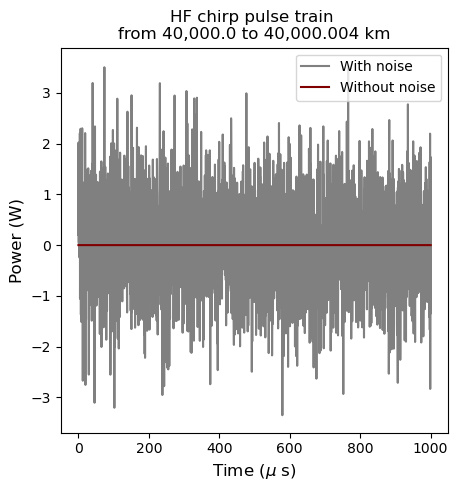

In [29]:
# set up range array
hf_Ae = (Gt*hf_wavelength**2)/(4*np.pi)
N_galactic = 10**-17 # W/mhz/m^2
N_power = N_galactic * (hf_bandwidth/1e6) * hf_Ae # W
print("Galactic noise (power): {} W".format(N_power))

start_alt = 40000*1e3 #m
end_time = 0.001 #s
vset = 4e3 #m/s
sampling_rate_m = vset/hf_repetition_freq
  
res, pulse_count, Pr = ranging_per_v(start_alt, end_time, sampling_rate_m, vset) # assume 4 km/s
noise_power = np.random.normal(loc=N_power, size=len(res)) # in units of amplitude (sqrt(W))

print(np.max(np.abs(res))) # amplitude (should be 1)
print("Uncompressed P_r/N (power): {:.2f} dB".format(10*np.log10(np.max(np.abs(Pr*res**2))/N_power)))

# Times for pulse train
times = np.linspace(0, pulse_count*(1/hf_repetition_freq), len(res)) 
# final time = number of pulses * repetition freq

# Plot figure
fig, ax = plt.subplots(figsize=(5,5))
plt.plot(times/(1e-6), Pr*res**2 + noise_power, c='gray', label='With noise')
plt.plot(times/(1e-6), Pr*res**2, c='maroon', label='Without noise')
plt.title("HF chirp pulse train \nfrom {:,} to {:,} km".format(start_alt/1e3, (start_alt + end_time*vset)/1e3), fontsize=12)
plt.xlabel(r"Time ($\mu$ s)", fontsize=12)
plt.ylabel("Power (W)", fontsize = 12)
plt.legend()

### 3) Pulse compress + estimate the phase correction + SNR
For each surface echoes series, implement pulse compression. Use the maxima of each compressed pulse to estimate the slope of the straight line that travels through, which will be the phase correction. 
Find the final summed, phase-corrected pulse to gather the SNR (power received / noise). 


Hmmm... should i be finding or guessing the phase correction? wouldnt we always be maxing out the snr each time?

In [97]:
# input: res array with pulse train (chirps), estimated phase correction
# output: SNR
from scipy.signal import find_peaks

def get_SNR(res, pulse_count, v, dtrue, dtest):
    # find phase correction for v
    phase_correction = 2*np.pi*v/hf_wavelength
    
    # Create the matched filter
    matchedfilter = np.tile(chirp(hf_s, hf_pulse_length, hf_fs, hf_fc, 1, int((1/hf_repetition_freq)*hf_fs), 0), pulse_count)
    
    # matched filter == fft(signal)*fft(filter) conjugate
    corr = np.fft.fftshift(np.fft.ifft(np.fft.fft(res)*np.conj(np.fft.fft(matchedfilter))))
    
    peaks, _ = find_peaks(corr, distance=int((1/hf_repetition_freq)*hf_fs))

    final_signal = np.zeros(2*int((1/hf_repetition_freq)*hf_fs/3), dtype=complex)
    times = np.arange(0, 1, 1/hf_fs) # array of times, 0 to 1 s
    
    for idx, peak in enumerate(peaks):
        # Define the time size for each pulse (INDEX)
        start = peak-int((1/hf_repetition_freq)*hf_fs/3)
        end = peak+int((1/hf_repetition_freq)*hf_fs/3)
        
        # Extract the pulse data
        pulse = corr[start:end]
        
        # if not enough data just leave it
        if start < 0: continue 
        if len(pulse) != len(final_signal): continue 
        
        # Apply phase correction (for each pulse number)
        # need to multiply by time
        corrected_pulse = pulse * np.exp(-1j * phase_correction * (idx+1) * (1/hf_fs)*(1/hf_repetition_freq) * np.arange(len(pulse)))
        final_signal += corrected_pulse
    
    
    # find peaks
    #plt.figure()
    #plt.plot(np.real(corr))
    #plt.scatter(peaks, np.zeros(len(peaks)), c='red', zorder=100)
    #pulse_times = np.arange(0, (2/3)*(1/hf_repetition_freq), 1/hf_fs)
    #plt.plot(pulse_times/(1e-6), np.real(final_signal))
    #plt.xlabel("Times (microseconds)")
    
    # shift with respect to dtrue
    delay_time = 2*dtrue/c

    # Calculate the shift index
    shift_index = np.argmin(np.abs(times-np.full(len(times), delay_time)))
    
    # Shift the signal array, pad with zeroes
    shifted_signal = np.concatenate([np.zeros(shift_index-int(len(final_signal)/2)), final_signal, np.zeros(len(times) - shift_index - int(len(final_signal)/2))])
    
    # max of final signal now aligns with shift_index of shifted_signal
    
    # Shifted signal view
    #plt.figure()
    #plt.plot(times, shifted_signal)
    #plt.xlim(times[shift_index-int(len(final_signal)/2)], times[shift_index+int(len(final_signal)/2)])
    
    # find the SNR at the given guessed altitude
    delay_time_guess = 2*dtest/c
    guess_index = np.argmin(np.abs(times-np.full(len(times), delay_time_guess)))
    amplitude_at_guess = np.abs(shifted_signal[guess_index])
    # AMPLITUDE at GUESS (sqrt(W))
    
    return peaks, amplitude_at_guess, times, shifted_signal

(266836.25, 266852.9166666667)

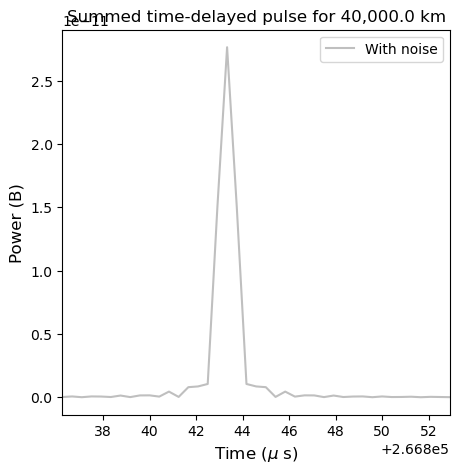

In [98]:
dtrue = 40000e3
#peaks, peak_sum_at_guess, shift_times, shifted_signal = get_SNR(res, pulse_count, 4000, dtrue, dtrue)
noise = np.random.normal(loc=np.sqrt(N_power), size=len(res)) # in units of amplitude (sqrt(W))
_, amplitude_at_guess, shift_times_noise, shifted_signal_noise = get_SNR(res*np.sqrt(Pr), pulse_count, 4000, dtrue, dtrue)
# units of Sqrt(W) -- amplitude

'''
fig, ax = plt.subplots(figsize=(5,5))
plt.plot(times/(1e-6), np.real(res), c='maroon')
plt.scatter(times[peaks]/(1e-6), np.zeros(len(peaks)), zorder=100)
plt.title("HF chirp pulse train \nfrom {:,} to {:,} km".format(start_alt/1e3, (start_alt + end_time*vset)/1e3), fontsize=12)
plt.xlabel(r"Time ($\mu$ s)", fontsize=12)
plt.ylabel("Amplitude", fontsize = 12)
'''

fig, ax = plt.subplots(figsize=(5,5))
plt.plot(shift_times_noise/(1e-6), np.abs(shifted_signal_noise)**2, c='gray', label='With noise', alpha=0.5)
#print(np.abs(amplitude_at_guess))
#plt.plot(shift_times/(1e-6), shifted_signal**2, c='maroon', label='Without noise', alpha=0.5)
plt.xlabel(r"Time ($\mu$ s)", fontsize=12)
plt.ylabel("Power (B)", fontsize = 12)
plt.title("Summed time-delayed pulse for {:,} km".format(dtrue/1e3))
plt.legend()
plt.xlim(shift_times_noise[np.argmax(shifted_signal_noise) - 20]/(1e-6), shift_times_noise[np.argmax(shifted_signal_noise) + 20]/(1e-6))

#### For one range, we get SNR per velocity:

Text(0, 0.5, 'SNR')

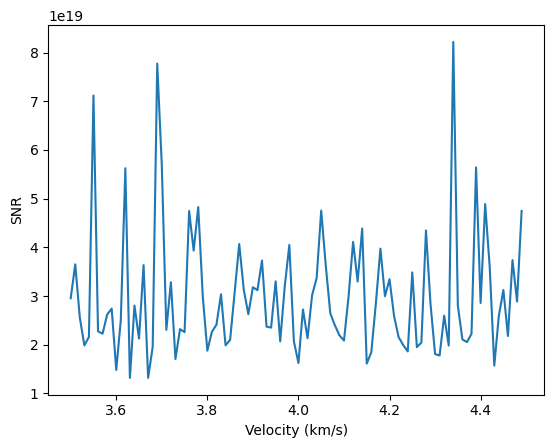

In [99]:
SNR_array = np.array([])
res, pulse_count, Pr = ranging_per_v(start_alt, end_time, 3.7e3/hf_repetition_freq, 3.7e3) # assume 4 km/s

for v in np.arange(3.5e3, 4.5e3, 0.01e3):
    noise = np.random.normal(loc=np.sqrt(N_power), size=len(res)) # in units of amplitude (sqrt(W))
    _, peak_sum, _, shifted_signal  = get_SNR(res*np.sqrt(Pr) + noise, pulse_count, v, 40000e3, 40000e3) # true alt=40000
    SNR = (np.abs(peak_sum)**2)/N_power # in units of power
    SNR_array = np.append(SNR_array, SNR)

plt.plot(np.arange(3.5e3, 4.5e3, 0.01e3)/1000, SNR_array)
plt.xlabel("Velocity (km/s)")
plt.ylabel("SNR")

Text(0, 0.5, 'SNR')

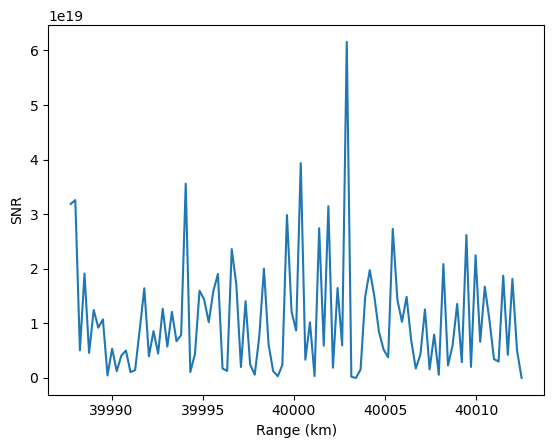

In [100]:
SNR_array = np.array([])
vset = 4e3
dtrue = 40000e3
dx = (1/3)*c*(1/hf_repetition_freq)/2 

for dguess in np.linspace(dtrue-dx, dtrue+dx, 100):
    sampling_rate_m = vset/hf_repetition_freq
    res, pulse_count, Pr = ranging_per_v(40000e3, end_time, sampling_rate_m, vset) # with true values

    _, peak_sum, _, shifted_signal = get_SNR(res*np.sqrt(Pr) + noise, pulse_count, vset, 40000e3, dguess)
    SNR = (np.abs(peak_sum)**2)/N_power # in units of power
    SNR_array = np.append(SNR_array, SNR)

plt.plot(np.linspace(dtrue-dx, dtrue+dx, 100)[1:]/1000, SNR_array[1:])
plt.xlabel("Range (km)") 
plt.ylabel("SNR")

### 4) Nested for loop -- many ranges + many velocities
Create a nested for loop implementing each above. Gather the true + recovered ranges, true + recovered velocities (convert phase correction -> velocity), SNR in a 5-value array. 

In [102]:
velocity_guesses = np.linspace(3.5e3, 4.5e3, 100) # m/s

end_time = 0.01 #s -- 40 PULSES

dtrue = 40000e3
vtrue = 3700 # m/s -- the actual velocity
dx = (1/3)*c*(1/hf_repetition_freq)/2 

# set up range array
hf_Ae = (Gt*hf_wavelength**2)/(4*np.pi)
N_galactic = 10**-17 # W/mhz/m^2
N_power = N_galactic * (hf_bandwidth/1e6) * hf_Ae # W

distance_guesses = np.linspace(dtrue-dx, dtrue+dx, 100)[1:] #m
#distance_guesses = [dtrue]

final_less = np.zeros((len(distance_guesses), len(velocity_guesses)))

sampling_rate_m = vtrue/hf_repetition_freq
res, pulse_count, Pr = ranging_per_v(dtrue, end_time, sampling_rate_m, vtrue) # with true values
    
for idd, d in enumerate(distance_guesses):
    # get ranging measurements (pulse train)
    for idv, v in enumerate(velocity_guesses):
        noise = np.random.normal(loc=np.sqrt(N_power), size=len(res)) # in units of amplitude (sqrt(W))
        _, peak_sum, _, _ = get_SNR(res*np.sqrt(Pr) + noise, pulse_count, v, dtrue, d)
        SNR = 10*np.log10((np.abs(peak_sum)**2)/N_power + (10**-25))
        final_less[idd, idv] = SNR

[[ 217.59012408  215.58356167  213.37271727 ...  215.16939431
   214.56270597  215.69542353]
 [ 216.57462248  223.72520953  207.76935951 ...  217.29151904
   216.24178342  221.48437417]
 [ 210.54048303  214.97673495  205.9933318  ...  224.34683667
   209.82396874  203.0770328 ]
 ...
 [ 220.78559623  223.38108317  212.81259033 ...  217.607386
   215.84971793  214.63623901]
 [ 218.36898216  215.49005571  218.21050768 ...  216.15413606
   214.00292439  219.61474872]
 [-250.         -250.         -250.         ... -250.
  -250.         -250.        ]]
Recovered range: 39988 km
Recovered velocity: 4.23 km/s


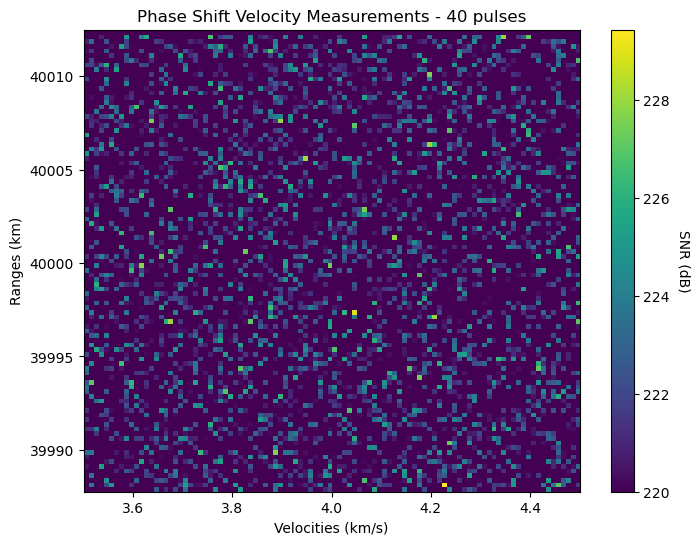

In [109]:
fig, ax = plt.subplots(figsize=(8, 6))
print(final_less)
heatmap = ax.imshow(final_less, cmap='viridis', origin="lower",aspect='auto', vmin = 220, 
              vmax = np.max(final_less), extent =[np.min(velocity_guesses/1e3), 
                                     np.max(velocity_guesses/1e3),np.min(distance_guesses/1e3), 
                                     np.max(distance_guesses/1e3)])

# Add colorbar
cbar = plt.colorbar(heatmap)
cbar.set_label('SNR (dB)', rotation=270, labelpad=15)

# Customize the plot
ax.set_ylabel('Ranges (km)')
ax.set_xlabel('Velocities (km/s)')
ax.set_title('Phase Shift Velocity Measurements - {} pulses'.format(pulse_count))

recovered_indices = np.unravel_index(final_less.argmax(), final_less.shape)
print("Recovered range: {:.0f} km".format(distance_guesses[recovered_indices[0]]/1e3))
print("Recovered velocity: {:.2f} km/s".format(velocity_guesses[recovered_indices[1]]/1e3))

### 5) Plot true vs. recovered range + true vs. recovered velocity 
Create true vs. recovered plots, colorcoded by SNR first to visualize general patterns. 

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(8, 4))
dmaxidx = np.argwhere(final_less==np.amax(final_less, axis=0, keepdims=True))
recovered_ranges = distance_guesses[dmaxidx[:,0]]/1e3

vmaxidx = np.argwhere(final_less==np.amax(final_less, axis=1, keepdims=True))
recovered_velocities = velocity_guesses[vmaxidx[:,1]]/1e3

binsd = np.linspace(np.min(recovered_ranges), np.max(recovered_ranges), 8)
binsv = np.linspace(np.min(recovered_velocities), np.max(recovered_velocities), 8)
ax[0].hist(recovered_ranges, color='#107394', bins=binsd)
ax[0].axvline(dtrue/1e3, ls='--', color='black')
ax[1].hist(recovered_velocities, color='#7b0829', bins=binsv)
ax[1].axvline(vtrue/1e3, ls='--', color='black')

ax[0].set_xlabel("Recovered ranges (km)", fontsize=10)
ax[0].set_ylabel("Frequency", fontsize=10)
ax[1].set_xlabel("Recovered velocities (km/s)", fontsize=10)
ax[1].set_ylabel("Frequency", fontsize=10)
ax[0].set_xlim(np.min(distance_guesses)/1e3 - 5, np.max(distance_guesses)/1e3 + 5)
ax[1].set_xlim(np.min(velocity_guesses)/1e3 - 0.1, np.max(velocity_guesses)/1e3 + 0.1)


# CALCULATE BIAS AND SCATTER
print(recovered_ranges)
range_bias = np.median(recovered_ranges - np.full(len(recovered_ranges), dtrue/1e3))
range_scatter = np.std(np.abs(recovered_ranges - np.full(len(recovered_ranges), dtrue/1e3)))
velocity_bias = np.median(recovered_velocities - np.full(len(recovered_velocities), vtrue/1e3))
velocity_scatter = np.std(np.abs(recovered_velocities - np.full(len(recovered_velocities), vtrue/1e3)))                    
                       
ax[0].text(x=0.05, y=0.93, s=r'$\mu$ = {:.2f} km'.format(range_bias), transform=ax[0].transAxes, color='#107394')
ax[0].text(x=0.05, y=0.87, s=r'$\sigma$ = {:.3f}'.format(range_scatter), transform=ax[0].transAxes, color='#107394')
ax[1].text(x=0.05, y=0.93, s=r'$\mu$ = {:.2f} km/s'.format(velocity_bias), transform=ax[1].transAxes, color='#7b0829')
ax[1].text(x=0.05, y=0.87, s=r'$\sigma$ = {:.3f}'.format(velocity_scatter), transform=ax[1].transAxes, color='#7b0829')
         
plt.tight_layout()

## INCREASE PULSES!

In [ ]:
velocity_guesses = np.linspace(3.5e3, 4.5e3, 50) # m/s

end_time = 0.1 #s -- 400 PULSES

dtrue = 42000e3
vtrue = 4000 # m/s -- the actual velocity
dx = (1/3)*c*(1/hf_repetition_freq)/2 

distance_guesses = np.linspace(dtrue-dx, dtrue+dx, 50)[1:] #m
#distance_guesses = [dtrue]

final_more = np.zeros((len(distance_guesses), len(velocity_guesses)))

sampling_rate_m = vtrue/hf_repetition_freq
res, pulse_count, Pr = ranging_per_v(dtrue, end_time, sampling_rate_m, vtrue) # with true values
    
for idd, d in enumerate(distance_guesses):
    # get ranging measurements (pulse train)
    for idv, v in enumerate(velocity_guesses):
        noise = np.random.normal(loc=np.sqrt(N_power), size=len(res)) # in units of amplitude (sqrt(W))
        _, peak_sum, _, _ = get_SNR(res*np.sqrt(Pr) + noise, pulse_count, v, dtrue, d)
        SNR = 10*np.log10((np.abs(peak_sum)**2)/N_power + (10**-25))
        final_more[idd, idv] = SNR

In [ ]:
fig, ax = plt.subplots(figsize=(8, 6))
print(final_more)
heatmap = ax.imshow(final_more, cmap='viridis', origin="lower",aspect='auto', vmin = 215, 
              vmax = np.max(final_more), extent =[np.min(velocity_guesses/1e3), 
                                     np.max(velocity_guesses/1e3),np.min(distance_guesses/1e3), 
                                     np.max(distance_guesses/1e3)])

# Add colorbar
cbar = plt.colorbar(heatmap)
cbar.set_label('SNR (dB)', rotation=270, labelpad=15)

# Customize the plot
ax.set_ylabel('Ranges (km)')
ax.set_xlabel('Velocities (km/s)')
ax.set_title('Phase Shift Velocity Measurements - {} pulses'.format(pulse_count))

recovered_indices = np.unravel_index(final_more.argmax(), final_more.shape)
print("SNR at recovered value: {:.2f} dB".format(final_more[recovered_indices]))
print("Recovered range: {:.0f} km".format(distance_guesses[recovered_indices[0]]/1e3))
print("Recovered velocity: {:.2f} km/s".format(velocity_guesses[recovered_indices[1]]/1e3))

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(8, 4))
dmaxidx = np.argwhere(final_more==np.amax(final_more, axis=0, keepdims=True))
recovered_ranges = distance_guesses[dmaxidx[:,0]]/1e3

vmaxidx = np.argwhere(final_more==np.amax(final_more, axis=1, keepdims=True))
recovered_velocities = velocity_guesses[vmaxidx[:,1]]/1e3

binsd = np.linspace(np.min(recovered_ranges), np.max(recovered_ranges), 8)
binsv = np.linspace(np.min(recovered_velocities), np.max(recovered_velocities), 8)
ax[0].hist(recovered_ranges, color='#107394', bins=binsd)
ax[0].axvline(dtrue/1e3, ls='--', color='black')
ax[1].hist(recovered_velocities, color='#7b0829', bins=binsv)
ax[1].axvline(vtrue/1e3, ls='--', color='black')

ax[0].set_xlabel("Recovered ranges (km)", fontsize=10)
ax[0].set_ylabel("Frequency", fontsize=10)
ax[1].set_xlabel("Recovered velocities (km/s)", fontsize=10)
ax[1].set_ylabel("Frequency", fontsize=10)

ax[0].set_xlim(np.min(distance_guesses)/1e3 - 5, np.max(distance_guesses)/1e3 + 5)
ax[1].set_xlim(np.min(velocity_guesses)/1e3 - 0.1, np.max(velocity_guesses)/1e3 + 0.1)


# CALCULATE BIAS AND SCATTER
print(recovered_ranges)
range_bias = np.median(recovered_ranges - np.full(len(recovered_ranges), dtrue/1e3))
range_scatter = np.std(np.abs(recovered_ranges - np.full(len(recovered_ranges), dtrue/1e3)))
velocity_bias = np.median(recovered_velocities - np.full(len(recovered_velocities), vtrue/1e3))
velocity_scatter = np.std(np.abs(recovered_velocities - np.full(len(recovered_velocities), vtrue/1e3)))                    
                       
ax[0].text(x=0.7, y=0.93, s=r'$\mu$ = {:.2f} km'.format(range_bias), transform=ax[0].transAxes, color='#107394')
ax[0].text(x=0.7, y=0.87, s=r'$\sigma$ = {:.3f}'.format(range_scatter), transform=ax[0].transAxes, color='#107394')
ax[1].text(x=0.05, y=0.93, s=r'$\mu$ = {:.2f} km/s'.format(velocity_bias), transform=ax[1].transAxes, color='#7b0829')
ax[1].text(x=0.05, y=0.87, s=r'$\sigma$ = {:.3f}'.format(velocity_scatter), transform=ax[1].transAxes, color='#7b0829')
         
plt.tight_layout()